# Model: LightGBM with Robust Time-Series 


In [0]:
# Load libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt

import pdb
import os
import gc; gc.enable()
import h5py
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [0]:
train = pd.read_csv("/content/train.csv.zip")
test = pd.read_csv("/content/test.csv.zip")

In [0]:
# Helper functions

# Function for loading h5py file
def load_h5py(fname):
    with h5py.File(fname, 'r') as handle:
        return handle['data'][:]
# Function for loading pickle file
def load_pickle(fname):
    with open(fname, 'rb') as handle:
        return pickle.load(handle)

# Function for saving data as pickle files
def save_as_pickle(fname, data):
    with open(fname, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Function for saving datasets in h5py format
def save_as_h5py(fname, data):
    data.drop(columns=['ID'], inplace=True)
    with h5py.File(fname, 'w') as handle:
        handle.create_dataset('data', data=data)
    return None

# Custom evaluation metric for LGBM
def RMSLE(preds, train_data):
    return 'RMSLE', np.sqrt(mean_squared_error(train_data.get_label(), preds)), False


# Function for evaluating mean errors
def average_best_scores(scores):
    s_cols = [c for c in scores.columns if c!='index']
    errs = scores[s_cols].apply(lambda x: np.min(x[x!=np.nan]), axis=0)
    return np.mean(errs)


# Function for plotting RMSLE averaged over all iterations
def plot_scores(t_scores, v_scores):
    s_cols = [c for c in t_scores.columns if c!='index']
    t_mean = np.mean(t_scores[s_cols], axis=1)
    t_mean = t_mean[~np.isnan(t_mean)]
    v_mean = np.mean(v_scores[s_cols], axis=1)
    v_mean = v_mean[~np.isnan(v_mean)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(v_mean, label='validation', c='lightblue', alpha=0.7)
    plt.plot(t_mean, label='training', c='blue', alpha=0.7)
    plt.title('Averaged Training and Validation Error')
    plt.xlabel('Training Iteration')
    plt.ylabel('RMSLE')
    plt.legend(loc='upper right')
    plt.show()
    return None


In [0]:
# Function for setting up
def get_input(debug=False):
    '''
    Function for loading either debug or full datasets
    '''
    os.chdir('/content/data/compressed/')
    print (os.getcwd())
    pkl_files = ['train_id.pickle', 'trainidx.pickle', 'target.pickle', 'test_id.pickle', 'testidx.pickle']
    if debug:
        print ('Loading debug train and test datasets...')
        # h5py files
        train = load_h5py('debug_train.h5')
        test = load_h5py('debug_test.h5')
        # pickle files
        id_train, train_idx, target, id_test, test_idx = [load_pickle('debug_%s'%f) for f in pkl_files]
    else:
        print ('Loading original train and test datasets...')
        # h5py files
        train = load_h5py('full_train.h5')
        test = load_h5py('full_test.h5')
        # pickle files
        id_train, train_idx, target, id_test, test_idx = [load_pickle('full_%s'%f) for f in pkl_files]
    # Load feature names
    fnames = load_pickle('feature_names.pickle')
    # Find shape of loaded datasets
    print('Shape of training dataset: {} Rows, {} Columns'.format(*train.shape))
    print('Shape of test dataset: {} Rows, {} Columns'.format(*test.shape))
    os.chdir('/content/scripts/')
    print (os.getcwd())
    return fnames, train, id_train, train_idx, target, test, id_test, test_idx

In [0]:
# Function for getting datasets in dataframe format
def get_dataframes(debug=False):
    # Load data
    fnames, train, id_train, train_idx, target, test, id_test, test_idx = get_input(debug)
    # Format data
    train_df = pd.DataFrame(data=train, index=train_idx, columns=fnames)
    train_df['ID'] = id_train
    train_df['target'] = target
    test_df = pd.DataFrame(data=test, index=test_idx, columns=fnames)
    test_df['ID'] = id_test
    
    print('\nShape of training dataframe: {} Rows, {} Columns'.format(*train_df.shape))
    print('Shape of test dataframe: {} Rows, {} Columns'.format(*test_df.shape))
    return fnames, train_df, test_df

In [0]:
# Function for loading leaks
def load_leaks(leak_val):
    leak_dir = '/content/data/data_leak/'
    
    train_leak_loc = leak_dir + 'train_leak_%s.csv'%leak_val
    train_leak = pd.read_csv(train_leak_loc).compiled_leak
    test_leak_loc = leak_dir + 'test_leak_%s.csv'%leak_val
    test_leak = pd.read_csv(test_leak_loc).compiled_leak
    
    return train_leak, test_leak

In [0]:
# Function for applying statistical transformations to data
def calculate_metadata(df):
    '''
    Function for calculating metadata across pandas dataframe row
    '''
    meta = pd.DataFrame()
    # Calculations that disregard zeros
    meta['nz_mean'] = df.apply(lambda x: x[x!=0].mean(), axis=1)
    meta['nz_log_mean_exp'] = df.apply(lambda x: np.expm1(np.mean(np.log1p(x[x!=0]))), axis=1)
    meta['nz_median'] = df.apply(lambda x: x[x!=0].median(), axis=1)
    meta['nz_std'] = df.apply(lambda x: x[x!=0].std(), axis=1)
    meta['nz_kurtosis'] = df.apply(lambda x: x[x!=0].kurtosis(), axis=1)
    meta['nz_min'] = df.apply(lambda x: np.min(x[x!=0]), axis=1)
    
    # Calculations independent of zeros
    meta['sum'] = df.apply(lambda x: np.sum(x), axis=1)
    meta['max'] = df.apply(lambda x: np.max(x), axis=1)
    
    # Calculations factoring in zeros
    meta['zero_count'] = df.apply(lambda x: np.count_nonzero(x==0), axis=1)
    meta['mean'] = df.apply(lambda x: x.mean(), axis=1)
    meta['log_mean_exp'] = df.apply(lambda x: np.expm1(np.mean(np.log1p(x))), axis=1)
    meta['median'] = df.apply(lambda x: x.median(), axis=1)
    meta['std'] = df.apply(lambda x: x.std(), axis=1)
    meta['kurtosis'] = df.apply(lambda x: x.kurtosis(), axis=1)
    
    return meta 

In [0]:
# Function for feature engineering
def format_for_training_v1(train, test, f, trn_leak, tst_leak, lagval=38):
    '''
    - Formats train and test dataframes for training
    '''
    tmp_trn = train.copy(deep=True)
    tmp_trn['leak'] = trn_leak
    tmp_trn['log_leak'] = np.log1p(tmp_trn['leak'])
    
    tmp_tst = test.copy(deep=True)
    tmp_tst['leak'] = tst_leak
    tmp_tst['log_leak'] = np.log1p(tmp_tst['leak'])
    
    score_name = '/content/model/model_2v2_featscores_%s.csv'%lagval
    print ('Loading file:\n', score_name)
    score_df = pd.read_csv(score_name, index_col=0)
    
    feature_list = load_pickle('/content/data/compressed/other_test.pickle')
    good_features = []
    for i in range(55):
        good_features += feature_list[i]
    
    print ('\nLoading metadata for training set...')
    trn_meta = pd.read_csv('content/meta_data/train_meta.csv')
    print ('Loading metadata for test set...')
    tst_meta = pd.read_csv('content/meta_data/test_meta.csv')
    
    # Format training and test datasets
    cols = ['ID'] + list(good_features) + list(trn_meta.columns.values) + ['log_leak']
    tmp_trn = pd.concat([tmp_trn, trn_meta], axis=1)
    tmp_tst = pd.concat([tmp_tst, tst_meta], axis=1)
    
    return tmp_trn[cols], tmp_tst[cols]


In [0]:
# Function for scaling datasets 
def scale_for_training(train, test):
    print ('Scaling data...')
    tmp_trn = train.copy(deep=True)
    tmp_trn.replace(np.nan, 0, inplace=True)
    tmp_tst = test.copy(deep=True)
    tmp_tst.replace(np.nan, 0, inplace=True)
    
    tmp_trn.drop(labels=['ID'], axis=1, inplace=True)
    tmp_tst.drop(labels=['ID'], axis=1, inplace=True)
    
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(tmp_trn)
    scaled_test = scaler.transform(tmp_tst)
    
    del tmp_trn, tmp_tst; gc.collect();
    return scaled_train, scaled_test

In [10]:
try:
    del fnames, train, test
    print ('Clearing loaded dataframes from memory...\n')
except:
    pass
fnames, train, test = get_dataframes(debug=False)

# Load leaks
leak_val = 36
print ('\nLoading train and test leaks...')
train_leak, test_leak = load_leaks(leak_val)
print ('Nonzero elements in train:', np.count_nonzero(train_leak))
print ('Nonzero elements in test:', np.count_nonzero(test_leak))

/content/data/compressed
Loading original train and test datasets...
Shape of training dataset: 4459 Rows, 4991 Columns
Shape of test dataset: 49342 Rows, 4991 Columns
/content/scripts

Shape of training dataframe: 4459 Rows, 4993 Columns
Shape of test dataframe: 49342 Rows, 4992 Columns

Loading train and test leaks...
Nonzero elements in train: 3840
Nonzero elements in test: 7820


In [11]:
# Get train and test in format for training booster
# Format target variable
target = train['target'].values
target_log = np.log1p(target)

pp_flag = False

train_name = '/content/data/compressed/btrain_%s.csv'%leak_val
test_name = '/content/data/compressed/btest_%s.csv'%leak_val
if pp_flag:
    btrain, btest = format_for_training_v1(train, test, fnames, train_leak, test_leak, leak_val)
    print ('\nSaving generated datasets...')
    btrain.to_csv(train_name, index=False)
    btest.to_csv(test_name, index=False)
else:
    print ('\nLoading generated datasets...')
    btrain = pd.read_csv(train_name)
    btest = pd.read_csv(test_name)

# Scale dataset for booster training
boost_train, boost_test = scale_for_training(btrain, btest)


Loading generated datasets...
Scaling data...


In [0]:
# Function for training a LGB Regressor
def train_lgb_regressor(train, target, test, params, n_boost=500):
    num_boosting = n_boost
    valid_result = pd.DataFrame(data=np.arange(num_boosting), columns=['index'])
    train_result = pd.DataFrame(data=np.arange(num_boosting), columns=['index'])
    test_predictions = np.zeros(test.shape[0])
    train_predictions = np.zeros(train.shape[0])
    kfold = KFold(n_splits=4)
    
    for i, (trn, val) in enumerate(kfold.split(train)):
        print ('\nTraining on fold:', i)
        round_name = 'round_%s'%i
        xtrain = train[trn, :]
        ytrain = target[trn]

        xval = train[val, :]
        yval = target[val]

        lgb_train = lgb.Dataset(xtrain, ytrain)
        lgb_eval = lgb.Dataset(xval, yval, reference=lgb_train)

        evals_result = {}
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=num_boosting,
                        valid_sets= (lgb_train, lgb_eval),
                        verbose_eval=500,
                        feval=RMSLE, 
                        evals_result=evals_result,
                        early_stopping_rounds=100)

        # Get evaluation results
        valid_res_df = pd.DataFrame.from_dict(evals_result['valid_1'], orient='columns')
        valid_res_df.rename(columns={'RMSLE': round_name}, inplace=True)
        valid_res_df.reset_index(inplace=True)
        train_res_df = pd.DataFrame.from_dict(evals_result['training'], orient='columns')
        train_res_df.rename(columns={'RMSLE': round_name}, inplace=True)
        train_res_df.reset_index(inplace=True)

        valid_result = pd.merge(valid_result, valid_res_df, how='outer', on='index')
        train_result = pd.merge(train_result, train_res_df, how='outer', on='index')

        # Make predictions
        test_predictions += (gbm.predict(test, num_iteration=gbm.best_iteration))/kfold.n_splits
        train_predictions += (gbm.predict(train, num_iteration=gbm.best_iteration))/kfold.n_splits
    
    return train_result, valid_result, test_predictions, train_predictions

# Function for evaluating trouble samples
trouble_idx = np.where(train_leak==0)[0]
def selective_eval(preds, target, idx):
    pred_subset = preds[idx]
    target_subset = target[idx]
    return mean_squared_error(pred_subset, target_subset)


In [0]:
# LGB Regressor Parameters
params = {'task': 'train',
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'RMSLE',
          'num_leaves': 18,
          'learning_rate': 0.05,
          'max_depth': -1,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'min_sum_hessian_in_leaf': 1e-3,
          'lambda_l2': 10,
          'verbose': 0}

In [0]:
# Tune LGB Regressor Hyper-Parameters
tune_flag = False
if tune_flag:
    cv_results = {}
    for cv_val in cv_set:
        print ('\nCross validating with %s: %s'%(cv_entry, cv_val))
        params[cv_entry] = cv_val
        train_res, valid_res, tst_preds, trn_preds = train_lgb_regressor(train=boost_train, 
                                                                         target=target_log, 
                                                                         test=boost_test, 
                                                                         params=params, 
                                                                         n_boost=30000)
        cv_results[cv_entry+'miss_train_val_%s'%cv_val] = (selective_eval(trn_preds, target_log, trouble_idx),
                                                           average_best_scores(train_res), 
                                                           average_best_scores(valid_res))
        
    # Show cv results
    print ('\nCV Results:')
    for key in cv_results.keys():
        print (key, cv_results[key])

In [15]:
# Confirm current parameter settings
train_res, valid_res, tst_preds, trn_preds = train_lgb_regressor(train=boost_train, 
                                                                 target=target_log, 
                                                                 test=boost_test, 
                                                                 params=params, 
                                                                 n_boost=30000)
train_score = average_best_scores(train_res)
valid_score = average_best_scores(valid_res)
print ('\nTraining score:', train_score)
print ('Validation score:', valid_score)
print ('\nTrouble score:', selective_eval(trn_preds, target_log, trouble_idx))


Training on fold: 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[90]	training's RMSLE: 0.390232	valid_1's RMSLE: 0.558706

Training on fold: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[150]	training's RMSLE: 0.363893	valid_1's RMSLE: 0.505681

Training on fold: 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[91]	training's RMSLE: 0.416564	valid_1's RMSLE: 0.496632

Training on fold: 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[147]	training's RMSLE: 0.347889	valid_1's RMSLE: 0.533418

Training score: 0.31161670295047167
Validation score: 0.5236091046336704

Trouble score: 1.1562860665636496


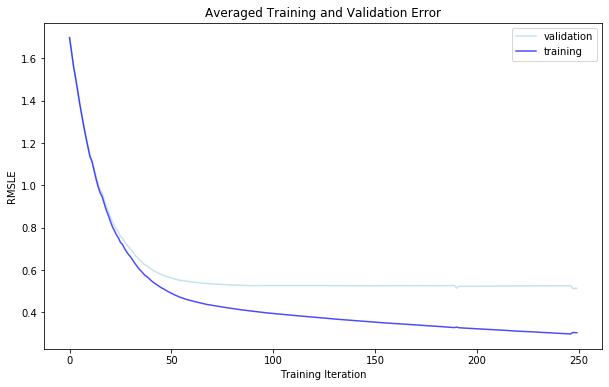

In [16]:
plot_scores(train_res, valid_res)

In [0]:
def make_target_v1(leak, preds):
    exp_preds = np.expm1(preds)
    
    fill_idx = np.where(leak==0)[0]
    
    tmp_leak = leak.copy()
    tmp_leak[fill_idx] = exp_preds[fill_idx]
    return tmp_leak

### Submission

In [18]:
# Make submission
save_flag=True

tst_target = make_target_v1(test_leak, tst_preds)

sub_name_tst = '/content/submissions/tstest_lgb_lag%s.csv'%leak_val


tst_df = pd.DataFrame()
tst_df['ID'] = test['ID']
tst_df['target'] = tst_target


if save_flag:
    tst_df.to_csv(sub_name_tst, index=False)
tst_df.head(15)

,ID,target
0,000137c73,2.818338e+06
1,00021489f,1.255667e+06
2,0004d7953,1.779918e+06
3,00056a333,3.005599e+06
4,00056d8eb,1.334687e+06
5,0005fc190,2.485740e+06
6,000787e86,1.035324e+06
7,0008510a0,2.125670e+06
8,000895faf,3.327137e+06
9,000986fba,2.490045e+06


### Leaderboard Score:
- **Public LB**: 0.51276
- **Private LB**: 0.55922
